In [6]:
## tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [7]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [8]:
# arxiv.invoke("what is the latest research on quantum computing?")

In [9]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki= WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [10]:
## set the environment variables
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [11]:
## Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [12]:
# tavily.invoke("Provide me the recent AI news")

In [13]:
## combine all these tools in the list
tools=[arxiv, wiki, tavily]

In [16]:
## Initialize the LLM Model

from langchain_groq import ChatGroq
llm=ChatGroq(
    model="qwen-qwq-32b"
)

In [ ]:
# llm.invoke("What is AI?")

AIMessage(content='\n<think>\nOkay, the user is asking, "What is AI?" I need to explain it clearly. Let me start by defining AI in simple terms. Maybe mention that AI stands for Artificial Intelligence. Then, I should explain what that means. I should differentiate between the general idea and the technical aspects.\n\nHmm, the user might not know much about this, so I should keep it basic. Maybe start with a straightforward definition: AI involves machines that can perform tasks requiring human intelligence. But wait, I should also touch on the different types of AI, like general vs. narrow AI. Oh right, examples help. Like Siri or self-driving cars.\n\nWait, I should also mention how AI works. Maybe talk about machine learning, neural networks, algorithms. But not too technical. The user might be curious about applications too—like healthcare, finance, etc. Also, maybe touch on common misconceptions, like the difference between AI and regular automation.\n\nShould I include a brief h

In [18]:
llm_with_tools = llm.bind_tools(tools=tools)

In [23]:
## Execute this call

# llm_with_tools.invoke("What is the recent news on AI?")
# llm_with_tools.invoke("What is the latest research on quantum computing?")
# llm_with_tools.invoke("What is machine learning?")

Workflow

In [26]:
## State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated ## labelling
from langgraph.graph.message import add_messages ## Reducers in langgraph

In [27]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # List of messages in the conversation

In [30]:
## Entire chatbot with langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

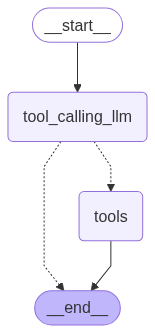

In [47]:
## Node definition
def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

## Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call ->  tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)

graph = builder.compile()

#  Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
messages=graph.invoke({"messages":"hi"})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hi! Hello to you too! 😊 How can I assist you today? Feel free to ask about anything!


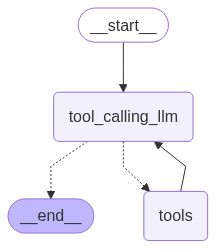

In [50]:
## Node definition
def tool_calling_llm(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

## Build Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call ->  tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")  # Loop back to tool calling node

graph = builder.compile()

#  Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
messages=graph.invoke({"messages":"What is the recent ai news and then please tell me about the resent research paper on quantum computing?"})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news and then please tell me about the resent research paper on quantum computing?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (kbm8aa799)
 Call ID: kbm8aa799
  Args:
    query: recent AI news 2023 breakthroughs and developments
  arxiv (e9tsebqnm)
 Call ID: e9tsebqnm
  Args:
    query: recent quantum computing research papers 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "2023 in AI: A Year of Breakthroughs and Boundless Possibilities", "url": "https://www.sagacify.com/news/2023-in-ai-a-year-of-breakthroughs-and-boundless-possibilities", "content": "As 2023 concludes, we find ourselves in awe of the significant transformations that have reshaped the landscape of artificial intelligence. This year has been a testament to th